In [1]:
from __future__ import unicode_literals, print_function, division

import glob
import os
import random
import time
import math
import torch
import torchvision
import unicodedata
import string
import itertools

import pandas as pd
import torch.nn as nn
import torchvision.transforms as transforms

from io import open
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Set Up

In [2]:
# Build the language_words dictionary, a list of words per language
def parseCSV(file):
    """returns pandas dataframe from CSV file"""
    data = pd.read_csv(file)
    return data

def reformatData(data):
    """takes in pandas dataframe and outputs data in right format"""
    language_words = defaultdict(list) 
    data = data.to_dict('split')['data']
    
    for entry in data:
        language_words[entry[1]].append(entry[0])
        
    return dict(language_words)

Parse our language dataset and populate four variables we will be using later:

training_words = `{'Simlish': ['Dag Dag', 'Zagadoo', ...], 'English': ['event', ...], ...}`

test_words = same format at training_words

all_languages = `['English', 'Spanish', 'Tolkien Elvish', ...]`

n_languages = 7

In [3]:
# parse the data for characters we need to include
csv_data = parseCSV('language_dataset.csv')
csv_data["Word"]= csv_data["Word"].str.lower()
language_words = reformatData(csv_data)

# populate all_letters with alphabet lower and upper 
# along with spaces and a few other punctuations
all_letters = set()

for letter in 'abcdefghijklmnopqrstuvwxyz' + " .,;'" + 'áéíóúüñàèìòùçâêîôûëïäöß()-āēīōū’ā̆ē̆ī̆ō̆ăĭḗū́u̯ṇ̃þʒ¹²/':
    all_letters.add(letter)

# we also need to include special characters found in certain languages
# primarily Tolkien Elvish and Spanish
for lang in language_words.keys():
    for word in language_words[lang]:
        for letter in word:
            all_letters.add(letter)      
            
n_letters = len(all_letters)
all_letters = sorted(list(all_letters))
print('n_letters:', n_letters)
print('all_letters:', all_letters)

n_letters: 82
all_letters: [' ', "'", '(', ')', ',', '-', '.', '/', ';', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '²', '¹', 'ß', 'à', 'á', 'â', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ñ', 'ò', 'ó', 'ô', 'ö', 'ù', 'ú', 'û', 'ü', 'þ', 'ā', 'ă', 'ē', 'ĕ', 'ī', 'ĭ', 'ō', 'ŏ', 'œ', 'ū', 'ƀ', 'ʒ', 'ˢ', '́', '̆', '̣', '̯', 'ṃ', 'ṇ', '’', '…']


In [4]:
# Turn names into tensors
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    try:
        if letter == '\xa0':
            letter = ' '
        return all_letters.index(letter)
    except:
        return None

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [5]:
# Turn a line into a <line_length x 1 x n_letters> tensor
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    language_i = top_i[0].item()
    return all_languages[language_i], language_i

In [6]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_languages) # choose a random language
    line = randomChoice(training_words[category]) # choose a random word from that language
    # turn the language into a 1D tensor
    category_tensor = torch.tensor([all_languages.index(category)], dtype=torch.long)
    # line_tensor is a 2D tensor containing a tensor for each letter
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        # Put the declaration of RNN network here
        self.hidden_size = hidden_size
    
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # Put the computation for forward pass here
        combined = torch.cat((input, hidden), 1)
        output = self.i2o(combined)
        output = self.softmax(output)
        hidden = self.i2h(combined)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [8]:
def train_iteration_CharRNN(learning_rate, category_tensor, line_tensor):
    criterion = nn.NLLLoss()
    hidden = rnn.initHidden()
    rnn.zero_grad()

    # The forward process
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    # The backward process
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()


In [9]:
def train_charRNN(n_iters, learning_rate, avg_loss_intervals):
    print_every = n_iters / avg_loss_intervals
    current_loss = 0
    losses = []

    def timeSince(since):
        now = time.time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

    start = time.time()

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output, loss = train_iteration_CharRNN(learning_rate, category_tensor, line_tensor)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (
                iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
            print('Average loss: %.4f' % (current_loss/print_every))
            losses.append(current_loss/print_every)
            current_loss = 0

    torch.save(rnn, 'char-rnn-classification.pt')
    return losses

In [10]:
# Finish the prediction function to provide predictions for any 
# input string (name) from the user
def predict(input_line, n_predictions=7):
#     print("Prediction for %s:" % input_line)
    hidden = rnn.initHidden()

    # Generate the input for RNN
    line_tensor = lineToTensor(input_line)
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    # Get the value and index of top K predictions from the output
    # Then apply Softmax function on the scores of all category predictions so we can 
    # output the probabilities that this name belongs to different languages.
    topv, topi = output.data.topk(n_predictions, 1, True)
    softmax = nn.Softmax(dim=1)
    top_prob = softmax(topv)
    predictions = []
 
    for i in range(3):
        value = topv[0][i]
        prob = top_prob[0][i] * 100
        category_index = topi[0][i]
#         print('%s Probability: (%.2f), Score: (%.2f)' % (all_languages[category_index], prob, value))
        predictions.append([value, all_languages[category_index]])
    return predictions

In [11]:
def getAccuracy(dataset):
    total_words = len(dataset.index)
    correct_predictions = 0
    for i in dataset.index:
        word = dataset['Word'][i]
        language = dataset['Language'][i]
        prediction = predict(word)[0][1]
        if prediction == language:
            correct_predictions += 1
    return correct_predictions / total_words

# Training the Model

In [12]:
# Accuracies for training the RNN model without stop words:
# n_iters=10000, learning_rate=0.02
# training data accuracy: 60.4129%
# testing data accuracy: 57.0018%

# n_iters=50000, learning_rate=0.005
# training data accuracy: 64.0934%
# testing data accuracy: 58.4381%

# n_iters=50000, learning_rate=0.008
# training data accuracy: 66.1580%
# testing data accuracy: 64.1831%

# n_iters=50000, learning_rate=0.01
# training data accuracy: 64.6095%
# testing data accuracy: 60.0539%

# n_iters=70000, learning_rate=0.008
# training data accuracy: 69.7711%
# testing data accuracy: 62.9264%

# n_iters=70000, learning_rate=0.005
# training data accuracy: 69.5691%
# testing data accuracy: 61.7594%

# n_iters=40000, learning_rate=0.008
# training data accuracy: 65.9785%
# testing data accuracy: 57.5404%

n_hidden = 128
n_iters = 50000 # number of iterations
learning_rate = 0.008
avg_loss_intervals = 25 # this is just how many avg losses points to display on the graph

## Stopwords Excluded

In [13]:
csv_data = parseCSV('language_dataset.csv')
csv_data["Word"]= csv_data["Word"].str.lower() 

train_data, test_data = train_test_split(csv_data, test_size=0.2)

training_words = reformatData(train_data)
testing_words = reformatData(test_data)

all_languages = list(training_words.keys())
n_languages = len(all_languages)

print('Number of Words per Language')
csv_data.groupby('Language').size()

Number of Words per Language


Language
English           898
French            942
German            884
Italian           940
Simlish           111
Spanish           919
Tolkien Elvish    876
dtype: int64

In [14]:
rnn = RNN(n_letters, n_hidden, n_languages)
stop_words_excluded_losses = train_charRNN(n_iters, learning_rate, avg_loss_intervals)

2000 4% (0m 5s) 1.7544 zo hungwah / Simlish ✓
Average loss: 1.8604
4000 8% (0m 11s) 1.5041 monture / Italian ✗ (French)
Average loss: 1.7061
6000 12% (0m 16s) 1.3138 horas / Spanish ✓
Average loss: 1.5725
8000 16% (0m 22s) 2.0053 offer / French ✗ (English)
Average loss: 1.4344
10000 20% (0m 27s) 1.7216 proper / French ✗ (English)
Average loss: 1.3749
12000 24% (0m 33s) 1.5539 early / Spanish ✗ (English)
Average loss: 1.2385
14000 28% (0m 38s) 0.5311 yibbsy / Simlish ✓
Average loss: 1.1728
16000 32% (0m 44s) 1.2736 laisser / German ✗ (French)
Average loss: 1.1749
18000 36% (0m 49s) 1.7939 trop / English ✗ (French)
Average loss: 1.1674
20000 40% (0m 54s) 0.0226 kalánt- / Tolkien Elvish ✓
Average loss: 1.1238
22000 44% (0m 58s) 0.4522 proprio / Italian ✓
Average loss: 1.1037
24000 48% (1m 3s) 0.8064 chica / Spanish ✓
Average loss: 1.0677
26000 52% (1m 8s) 0.9232 venir / Spanish ✗ (French)
Average loss: 1.1151
28000 56% (1m 13s) 1.2195 de metal / German ✗ (Spanish)
Average loss: 1.0818
300

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [15]:
# plt.plot(stop_words_excluded_losses)
# plt.xlabel('Training Iteration * {}'.format(int(n_iters / avg_loss_intervals)))
# plt.ylabel('Average Loss per {} Iterations'.format(int(n_iters / avg_loss_intervals)))
# plt.title('Average Loss for RNN Model Stopwords Excluded')
# plt.show()

In [17]:
stop_words_excluded_train_acc = getAccuracy(train_data) * 100
stop_words_excluded_test_acc = getAccuracy(test_data) * 100

## Stopwords Included

In [18]:
csv_data = parseCSV('language_dataset_with_stopwords.csv')
train_data, test_data = train_test_split(csv_data, test_size=0.2)

training_words = reformatData(train_data)
testing_words = reformatData(test_data)

all_languages = list(training_words.keys())
n_languages = len(all_languages)

print('Number of Words per Language')
csv_data.groupby('Language').size()

Number of Words per Language


Language
English           1000
French            1000
German            1000
Italian           1000
Simlish            111
Spanish           1000
Tolkien Elvish     894
dtype: int64

In [19]:
rnn = RNN(n_letters, n_hidden, n_languages)
stop_words_included_losses = train_charRNN(n_iters, learning_rate, avg_loss_intervals)

2000 4% (0m 4s) 1.2940 protokollieren / German ✓
Average loss: 1.7857
4000 8% (0m 9s) 1.7669 magasin / French ✓
Average loss: 1.5811
6000 12% (0m 14s) 0.8422 arthā / Tolkien Elvish ✓
Average loss: 1.4417
8000 16% (0m 19s) 1.1221 while / English ✓
Average loss: 1.3411
10000 20% (0m 24s) 0.8238 cou / Simlish ✓
Average loss: 1.2489
12000 24% (0m 29s) 1.6356 organizzare / French ✗ (Italian)
Average loss: 1.2247
14000 28% (0m 34s) 0.7487 lotta / Italian ✓
Average loss: 1.1755
16000 32% (0m 39s) 1.7115 donde / Tolkien Elvish ✗ (Spanish)
Average loss: 1.1263
18000 36% (0m 44s) 0.1562 stīrē / Tolkien Elvish ✓
Average loss: 1.0856
20000 40% (0m 48s) 2.3949 rigelle / Italian ✗ (Tolkien Elvish)
Average loss: 1.0619
22000 44% (0m 53s) 0.2995 erhalten / German ✓
Average loss: 1.1175
24000 48% (0m 58s) 0.9763 raika / Simlish ✗ (Tolkien Elvish)
Average loss: 1.0486
26000 52% (1m 3s) 0.0012 Zahl / German ✓
Average loss: 1.0350
28000 56% (1m 8s) 3.4530 chose / English ✗ (French)
Average loss: 1.0189
30

In [20]:
# plt.plot(stop_words_included_losses)
# plt.xlabel('Training Iteration * {}'.format(int(n_iters / avg_loss_intervals)))
# plt.ylabel('Average Loss per {} Iterations'.format(int(n_iters / avg_loss_intervals)))
# plt.title('Average Loss for RNN Model Stopwords Included')
# plt.show()

In [21]:
stop_words_included_train_acc = getAccuracy(train_data) * 100
stop_words_included_test_acc = getAccuracy(test_data) * 100

## Difficult Words Only

In [22]:
csv_data = parseCSV('difficult_set.csv')
train_data, test_data = train_test_split(csv_data, test_size=0.2)

training_words = reformatData(train_data)
testing_words = reformatData(test_data)

all_languages = list(training_words.keys())
n_languages = len(all_languages)

print('Number of Words per Language')
csv_data.groupby('Language').size()

Number of Words per Language


Language
English           882
French            790
German            862
Italian           811
Simlish           111
Spanish           821
Tolkien Elvish    893
dtype: int64

In [23]:
rnn = RNN(n_letters, n_hidden, n_languages)
difficult_words_losses = train_charRNN(n_iters, learning_rate, avg_loss_intervals)

2000 4% (0m 5s) 0.0319 Raum / German ✓
Average loss: 1.7739
4000 8% (0m 10s) 0.9094 strano / Italian ✓
Average loss: 1.5751
6000 12% (0m 15s) 1.1883 kat / Simlish ✓
Average loss: 1.4483
8000 16% (0m 19s) 1.1444 mī / Tolkien Elvish ✓
Average loss: 1.3218
10000 20% (0m 25s) 1.1495 patio / Italian ✗ (Spanish)
Average loss: 1.2896
12000 24% (0m 30s) 0.4113 dwam / Simlish ✓
Average loss: 1.2217
14000 28% (0m 35s) 0.5480 cima / Spanish ✓
Average loss: 1.1422
16000 32% (0m 40s) 1.3841 let / German ✗ (English)
Average loss: 1.0767
18000 36% (0m 45s) 1.1392 ilana / Simlish ✓
Average loss: 1.0721
20000 40% (0m 50s) 1.1818 différer / French ✓
Average loss: 1.0996
22000 44% (0m 55s) 0.1709 khādo / Tolkien Elvish ✓
Average loss: 1.0058
24000 48% (1m 0s) 1.1908 demás / Spanish ✓
Average loss: 1.0158
26000 52% (1m 6s) 0.5026 esclavo / Spanish ✓
Average loss: 0.9683
28000 56% (1m 11s) 1.5270 Absatz / Spanish ✗ (German)
Average loss: 0.9619
30000 60% (1m 15s) 0.3682 pezzo / Italian ✓
Average loss: 0.96

In [24]:
# plt.plot(difficult_words_losses)
# plt.xlabel('Training Iteration * {}'.format(int(n_iters / avg_loss_intervals)))
# plt.ylabel('Average Loss per {} Iterations'.format(int(n_iters / avg_loss_intervals)))
# plt.title('Average Loss for RNN Model Difficult Words')
# plt.show()

In [25]:
difficult_words_only_train_acc = getAccuracy(train_data) * 100
difficult_words_only_test_acc = getAccuracy(test_data) * 100

# Results

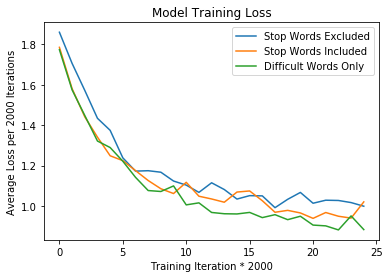

In [28]:
plt.plot(stop_words_excluded_losses)
plt.plot(stop_words_included_losses)
plt.plot(difficult_words_losses)
plt.title('Model Training Loss')
plt.xlabel('Training Iteration * {}'.format(int(n_iters / avg_loss_intervals)))
plt.ylabel('Average Loss per {} Iterations'.format(int(n_iters / avg_loss_intervals)))
plt.legend(['Stop Words Excluded', 'Stop Words Included', 'Difficult Words Only'], loc='upper right')
plt.show()

In [29]:
print('stop words excluded training data accuracy: {:.4f}%'.format(stop_words_excluded_train_acc))
print('stop words excluded testing data accuracy: {:.4f}%'.format(stop_words_excluded_test_acc))
print()
print('stop words included training data accuracy: {:.4f}%'.format(stop_words_included_train_acc))
print('stop words included testing data accuracy: {:.4f}%'.format(stop_words_included_test_acc))
print()
print('difficult words only training data accuracy: {:.4f}%'.format(difficult_words_only_train_acc))
print('difficult words only testing data accuracy: {:.4f}%'.format(difficult_words_only_test_acc))

stop words excluded training data accuracy: 60.9515%
stop words excluded testing data accuracy: 53.2316%

stop words included training data accuracy: 63.5096%
stop words included testing data accuracy: 62.6145%

difficult words only training data accuracy: 65.9333%
difficult words only testing data accuracy: 59.3810%


## Only Words Greater than Two Characters Long Included

In [ ]:
# csv_data = parseCSV('language_dataset_with_stopwords.csv')
# filtered_data = csv_data[csv_data['Word'].apply(lambda x: len(x) > 2)]
# train_data, test_data = train_test_split(filtered_data, test_size=0.2)

# training_words = reformatData(train_data)
# testing_words = reformatData(test_data)

# all_languages = list(training_words.keys())
# n_languages = len(all_languages)

# print('Number of Words per Language')
# filtered_data.groupby('Language').size()

In [ ]:
# rnn = RNN(n_letters, n_hidden, n_languages)
# losses = train_charRNN(n_iters, learning_rate, avg_loss_intervals)

In [ ]:
# plt.plot(losses)
# plt.xlabel('Training Iteration * {}'.format(int(n_iters / avg_loss_intervals)))
# plt.ylabel('Average Loss per {} Iterations'.format(int(n_iters / avg_loss_intervals)))
# plt.title('Average Loss for RNN Model Only Words Greater than 2 Char Long')
# plt.show()

In [ ]:
# print('training data accuracy: {:.4f}%'.format(getAccuracy(train_data) * 100))
# print('testing data accuracy: {:.4f}%'.format(getAccuracy(test_data) * 100))

## Only Words Greater than Three Characters Long Included

In [ ]:
# csv_data = parseCSV('language_dataset_with_stopwords.csv')
# filtered_data = csv_data[csv_data['Word'].apply(lambda x: len(x) > 3)]
# train_data, test_data = train_test_split(filtered_data, test_size=0.2)

# training_words = reformatData(train_data)
# testing_words = reformatData(test_data)

# all_languages = list(training_words.keys())
# n_languages = len(all_languages)

# print('Number of Words per Language')
# filtered_data.groupby('Language').size()

In [ ]:
# rnn = RNN(n_letters, n_hidden, n_languages)
# losses = train_charRNN(n_iters, learning_rate, avg_loss_intervals)

In [ ]:
# plt.plot(losses)
# plt.xlabel('Training Iteration * {}'.format(int(n_iters / avg_loss_intervals)))
# plt.ylabel('Average Loss per {} Iterations'.format(int(n_iters / avg_loss_intervals)))
# plt.title('Average Loss for RNN Model Only Words Greater than 3 Char Long')
# plt.show()

In [ ]:
# print('training data accuracy: {:.4f}%'.format(getAccuracy(train_data) * 100))
# print('testing data accuracy: {:.4f}%'.format(getAccuracy(test_data) * 100))